In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import os
from collections import defaultdict
import zipfile
import umap
import re
import scipy.io
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
filename = r'V:\Ca_imaging_pain\4_fluorescence_traces\JH_322_raw_deltaF_over_F.mat'

with h5py.File(filename, 'r') as file:
    print(list(file.keys()))

['#refs#', 'dFF']


In [4]:
with h5py.File(filename, 'r') as file:
    # Access the 'dFF' cell array
    dff = file['dFF']

    # Specify the cell indices you want to access, e.g., (row, column)
    row_index = 0  # Assuming you want the first row
    col_index = 1  # Assuming you want the second column

    # Get the HDF5 reference for the specific cell
    ref = dff[row_index, col_index]

    # Dereference to get the data
    data = np.array(file[ref])

    # Now, 'data' contains the contents of the specified cell
    print(data)


[[-0.22213796]
 [-0.21399613]
 [-0.13897477]
 ...
 [-0.0843081 ]
 [-0.09070528]
 [-0.06453504]]


In [5]:
data.shape

(8925, 1)

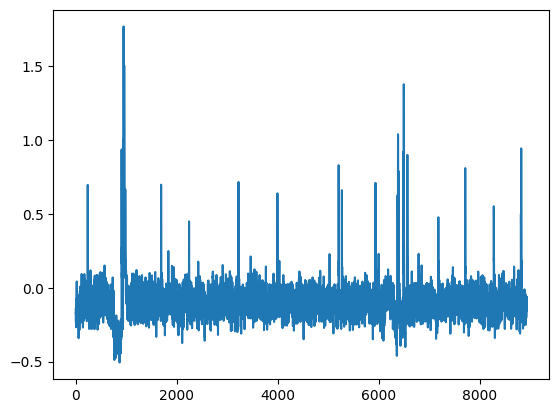

In [6]:
plt.plot(data)

## Step 2: Load the Data

In [7]:
path_to_extracted_folder = 'D:/deeplabcut/BSOID/'
data_files = os.listdir(path_to_extracted_folder)
saline_files = [file for file in data_files if any(mouse in file for mouse in ['322', '328', '330', '332'])]
pfa_files = [file for file in data_files if any(mouse in file for mouse in ['326', '327', '334', '335', '336'])]

saline_dataframes = [pd.read_csv('D:/deeplabcut/BSOID/' + file, header=[1,2]) for file in saline_files]
pfa_dataframes = [pd.read_csv('D:/deeplabcut/BSOID/' + file, header=[1,2]) for file in pfa_files]

saline_dataframes_cropped = saline_dataframes
pfa_dataframes_cropped = pfa_dataframes

frame_info_df_manual = pd.read_csv(r'H:\DANNCE\6cam_behavior\topviewcam\top_view_cam_led_frames.csv')
# for f in range(len(saline_dataframes)):
#     shape = saline_dataframes_cropped[f].shape[0]
#     print(f"The number of rows in saline_dataframes[{f}] is {shape}")
# for f in range(len(pfa_dataframes)):
#     shape = pfa_dataframes_cropped[f].shape[0]
#     print(f"The number of rows in pfa_dataframes[{f}] is {shape}")


In [8]:
def crop_dataframe(df, file_name):
    # Adjust the logic here to correctly extract the mouse name
    parts = file_name.split('DLC')
    mouse_name = parts[0].split('Hz')[1].rstrip('_')  # This should correctly extract the mouse name

    # Now, find the start frame
    start_frame = frame_info_df_manual[frame_info_df_manual['Filename'] == mouse_name]['Start'].values[0]
    return df.iloc[start_frame : start_frame + 53250]

saline_dataframes_cropped = [crop_dataframe(df, file) for df, file in zip(saline_dataframes, saline_files)]
pfa_dataframes_cropped = [crop_dataframe(df, file) for df, file in zip(pfa_dataframes, pfa_files)]
# for f in range(len(saline_dataframes)):
#     shape = saline_dataframes_cropped[f].shape[0]
#     print(f"The number of rows in saline_dataframes[{f}] is {shape}")
# for f in range(len(pfa_dataframes)):
#     shape = pfa_dataframes_cropped[f].shape[0]
#     print(f"The number of rows in pfa_dataframes[{f}] is {shape}")

In [10]:
def clean_data_modified(df):
    # Create a copy of the dataframe
    df_copy = df.copy()
    
    # Replace missing values or NaN with interpolation on the copy
    df_copy.interpolate(method='linear', inplace=True, limit_direction='both')
    
    return df_copy

# Applying the modified function to the cropped dataframes
saline_dataframes_cleaned = [clean_data_modified(df) for df in saline_dataframes_cropped]
pfa_dataframes_cleaned = [clean_data_modified(df) for df in pfa_dataframes_cropped]
downsampled_saline_dataframes = [df.iloc[::6] for df in saline_dataframes_cleaned]
downsampled_pfa_dataframes = [df.iloc[::6] for df in pfa_dataframes_cleaned]


## connect the data with BSOID

In [63]:
def group_indices_by_label(df):
    indices_groups = defaultdict(list)
    # Accessing the second column by its position
    labels = df.iloc[:, 1].tolist()
    for i, label in enumerate(labels):
        indices_groups[label].append(i)
    return indices_groups

# Example usage
indices_groups_list = []
for df in downsampled_pfa_dataframes:
    indices_groups = group_indices_by_label(df)
    indices_groups_list.append(indices_groups)

# 'indices_groups_list' now contains the indices grouped by labels for each DataFrame


In [65]:
# Iterate over each key in indices_groups
for file in np.arange(10):
    print(len(indices_groups_list[file][24])/5)

9.2
125.6
11.6
90.0
1.2
69.8
1.2
42.0
5.4
14.4


In [50]:
len(indices_groups_list[1][24])

31

In [23]:
# Assuming 'df' is your DataFrame and 'indices_groups' is the dictionary with indices
file_of_interest =5  # This is the label you're interested in
indices_for_label = indices_groups_list[file_of_interest]['24']
len(indices_for_label)

0

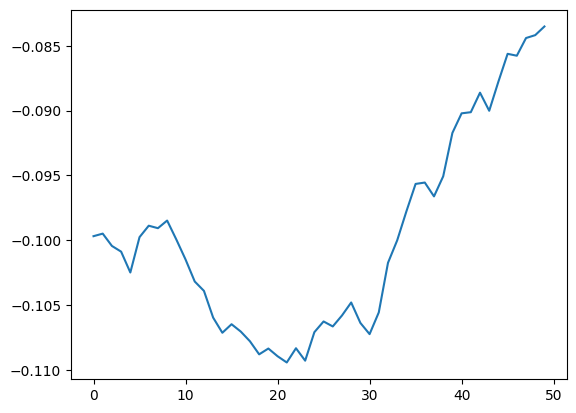

In [13]:
data_slices = []
SR = 5
sec = SR* 5
for i in indices_for_label:
    if (i - sec) < 0 or (i + sec) > len(data):
        # Skip if the range goes out of the data bounds
        continue
    data_slices.append(data[i-sec:i+sec])

# Convert the list of slices into a 2D NumPy array for easier calculation
data_array = np.array(data_slices)

# Calculate the average trace
avg_trace = np.mean(data_array, axis=0)

# Plot the average trace
plt.plot(avg_trace)
plt.show()

In [153]:
data[0]

array([-0.22213796])

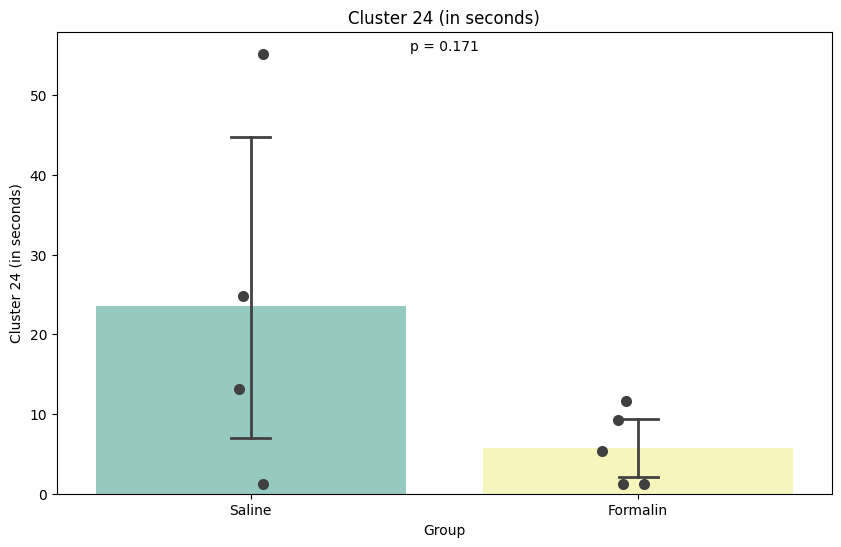

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import mannwhitneyu
import numpy as np

# 1. Define the data in frames
control_group_frames = [1.2 , 24.8, 13.2, 55.2]
pfa_group_frames = [9.2,11.6,1.2,1.2,5.4]

# 2. Convert frames to seconds (30 fps)
control_group_seconds = [x for x in control_group_frames]
pfa_group_seconds = [x for x in pfa_group_frames]

# 3. Create a DataFrame for easier plotting
data_seconds = pd.DataFrame({
    'Time Spent (s)': control_group_seconds + pfa_group_seconds,
    'Group': ['Saline'] * len(control_group_seconds) + ['Formalin'] * len(pfa_group_seconds)
})

# 4. Perform Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(control_group_seconds, pfa_group_seconds)

# 5. Create the plot with mean +/- sd
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Group', y='Time Spent (s)', data=data_seconds, palette="Set3", capsize=0.1, err_kws={'linewidth': 2}, hue='Group', legend=False)
sns.stripplot(x='Group', y='Time Spent (s)', data=data_seconds, color=".25", size=8, jitter=True)
plt.title('Cluster 24 (in seconds)')
plt.ylabel('Cluster 24 (in seconds)')
plt.xlabel('Group')

# 6. Annotate with p-value
plt.text(0.5, max(data_seconds['Time Spent (s)']), f'p = {p_value:.3f}', ha='center', va='bottom')

plt.show()


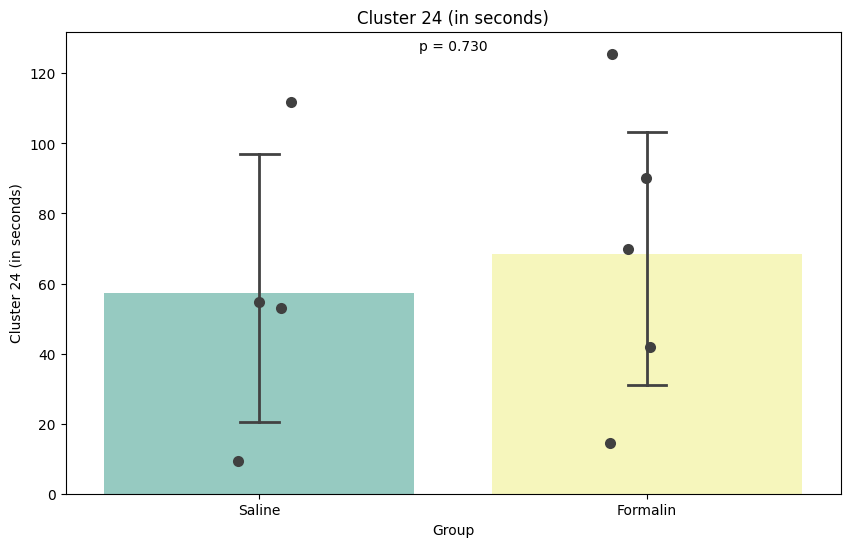

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import mannwhitneyu
import numpy as np

# 1. Define the data in frames
control_group_frames = [9.2 , 53.0, 54.8, 111.8]
pfa_group_frames = [125.6,90.0,69.8,42.0,14.4]

# 2. Convert frames to seconds (30 fps)
control_group_seconds = [x for x in control_group_frames]
pfa_group_seconds = [x for x in pfa_group_frames]

# 3. Create a DataFrame for easier plotting
data_seconds = pd.DataFrame({
    'Time Spent (s)': control_group_seconds + pfa_group_seconds,
    'Group': ['Saline'] * len(control_group_seconds) + ['Formalin'] * len(pfa_group_seconds)
})

# 4. Perform Mann-Whitney U test
u_statistic, p_value = mannwhitneyu(control_group_seconds, pfa_group_seconds)

# 5. Create the plot with mean +/- sd
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Group', y='Time Spent (s)', data=data_seconds, palette="Set3", capsize=0.1, err_kws={'linewidth': 2}, hue='Group', legend=False)
sns.stripplot(x='Group', y='Time Spent (s)', data=data_seconds, color=".25", size=8, jitter=True)
plt.title('Cluster 24 (in seconds)')
plt.ylabel('Cluster 24 (in seconds)')
plt.xlabel('Group')

# 6. Annotate with p-value
plt.text(0.5, max(data_seconds['Time Spent (s)']), f'p = {p_value:.3f}', ha='center', va='bottom')

plt.show()


In [72]:
9.2
125.6
11.6
90.0
1.2
69.8
1.2
42.0
5.4
14.4

14.4

In [73]:
1.2
9.2
24.8
53.0
13.2
54.8
55.2
111.8

111.8

C:\Users\huang\AppData\Local\Temp\ipykernel_11204\1456195319.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(x='Saline', y='Time Spent', data=data_before_after, palette="vlag", capsize=0.1, errwidth=2, ci='sd')
C:\Users\huang\AppData\Local\Temp\ipykernel_11204\1456195319.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Saline', y='Time Spent', data=data_before_after, palette="vlag", capsize=0.1, errwidth=2, ci='sd')
C:\Users\huang\AppData\Local\Temp\ipykernel_11204\1456195319.py:26: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  ax = sns.barplot(x='Saline', y='Time Spent', data=data_before_after, palette="vlag", capsize=0.1, errwidth=2, ci='sd')
C:\Users\huang\AppData\Loc

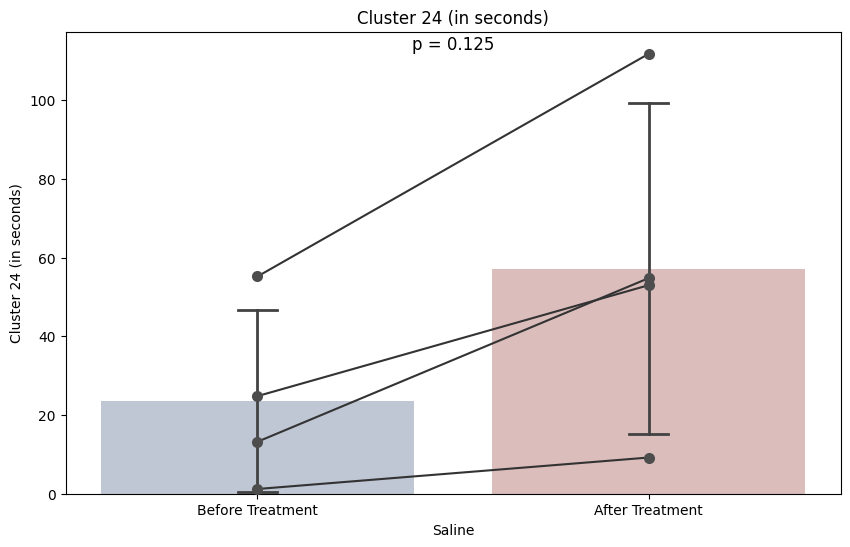

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import wilcoxon

# Data: Number of frames before and after treatment
frames_before = [1.2 , 24.8, 13.2, 55.2]
frames_after = [9.2 , 53.0, 54.8, 111.8]

# Convert the number of frames to time in seconds (30 frames per second)
time_before = [frames for frames in frames_before]
time_after = [frames for frames in frames_after]

# Create a DataFrame for easier plotting
data_before_after = pd.DataFrame({
    'Time Spent': time_before + time_after,
    'Saline': ['Before Treatment'] * len(time_before) + ['After Treatment'] * len(time_after),
    'Subject': ['Animal 1', 'Animal 2', 'Animal 3', 'Animal 4'] * 2
})

# Perform Wilcoxon signed-rank test
w_statistic, p_value = wilcoxon(time_before, time_after)

# Create the bar plot with mean +/- sd and data points
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Saline', y='Time Spent', data=data_before_after, palette="vlag", capsize=0.1, errwidth=2, ci='sd')
ax = sns.stripplot(x='Saline', y='Time Spent', data=data_before_after, size=8, color=".3", linewidth=0, dodge=False, jitter=False)

# Connect the self controlled data points
for i in range(len(time_before)):
    plt.plot(['Before Treatment', 'After Treatment'], [time_before[i], time_after[i]], 'k-', color="0.2")

ax.text(0.5, max(time_before + time_after), f'p = {p_value:.3f}', 
        ha='center', va='bottom', color='black', fontsize=12)

plt.title('Cluster 24 (in seconds)')
plt.ylabel('Cluster 24 (in seconds)')
plt.xlabel('Saline')
plt.show()


C:\Users\huang\AppData\Local\Temp\ipykernel_11204\2161036235.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(x='Formalin', y='Time Spent', data=data_before_after, palette="vlag", capsize=0.1, errwidth=2, ci='sd')
C:\Users\huang\AppData\Local\Temp\ipykernel_11204\2161036235.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Formalin', y='Time Spent', data=data_before_after, palette="vlag", capsize=0.1, errwidth=2, ci='sd')
C:\Users\huang\AppData\Local\Temp\ipykernel_11204\2161036235.py:26: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  ax = sns.barplot(x='Formalin', y='Time Spent', data=data_before_after, palette="vlag", capsize=0.1, errwidth=2, ci='sd')
C:\Users\huang\AppDa

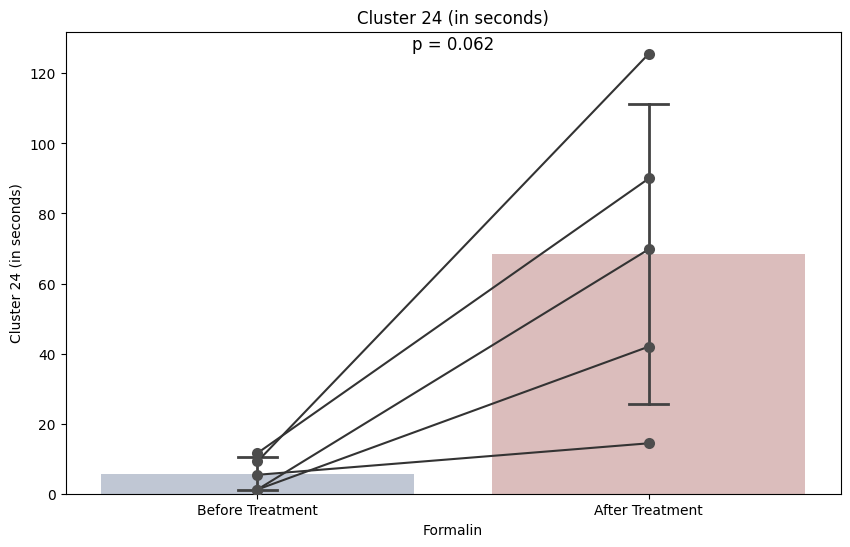

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import wilcoxon

# Data: Number of frames before and after treatment
frames_before = [9.2,11.6,1.2,1.2,5.4]
frames_after = [125.6,90.0,69.8,42.0,14.4]

# Convert the number of frames to time in seconds (30 frames per second)
time_before = [frames for frames in frames_before]
time_after = [frames for frames in frames_after]

# Create a DataFrame for easier plotting
data_before_after = pd.DataFrame({
    'Time Spent': time_before + time_after,
    'Formalin': ['Before Treatment'] * len(time_before) + ['After Treatment'] * len(time_after),
    'Subject': ['Animal 1', 'Animal 2', 'Animal 3', 'Animal 4', 'Animal 5'] * 2
})

# Perform Wilcoxon signed-rank test
w_statistic, p_value = wilcoxon(time_before, time_after)

# Create the bar plot with mean +/- sd and data points
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Formalin', y='Time Spent', data=data_before_after, palette="vlag", capsize=0.1, errwidth=2, ci='sd')
ax = sns.stripplot(x='Formalin', y='Time Spent', data=data_before_after, size=8, color=".3", linewidth=0, dodge=False, jitter=False)

# Connect the self controlled data points
for i in range(len(time_before)):
    plt.plot(['Before Treatment', 'After Treatment'], [time_before[i], time_after[i]], 'k-', color="0.2")

ax.text(0.5, max(time_before + time_after), f'p = {p_value:.3f}', 
        ha='center', va='bottom', color='black', fontsize=12)

plt.title('Cluster 24 (in seconds)')
plt.ylabel('Cluster 24 (in seconds)')
plt.xlabel('Formalin')
plt.show()
